In [136]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [137]:
def get_gravity(altitude_ASL):
    """
    Returns gravitational acceleration as a function of altitude above sea level (ASL).
    This function approximates Earth's gravity assuming a perfect sphere.

    Parameters:
    altitude_ASL (float): Altitude above sea level in meters.

    Returns:
    float: Gravitational acceleration at the given altitude in m/s².
    """

    g_0 = -9.80665  # Standard gravity at sea level (m/s²)
    R_e = 6371000  # Earth's radius in meters

    # Gravity decreases with altitude according to the inverse-square law
    g = g_0 * (R_e / (R_e + altitude_ASL)) ** 2
    
    return g
def get_air_density(altitude_ASL):
    """
    Returns air density as a function of altitude above sea level (ASL).
    This is valid up to an altitude of 11 kilometers, and it uses the barometric formula
    assuming a constant temperature lapse rate in the troposphere.

    Parameters:
    altitude_ASL (float): Altitude above sea level in meters.

    Returns:
    float: Air density at the given altitude in kg/m³.
    """

    p_0 = 101325  # Standard sea level atmospheric pressure in Pascals
    M = 0.0289652  # Molar mass of dry air in kg/mol
    R = 8.31445  # Universal gas constant in J/(mol·K)
    T_0 = 288.15  # Standard sea level temperature in Kelvin
    L = 0.0065  # Temperature lapse rate in K/m

    # Get gravity at the specified altitude
    g = get_gravity(altitude_ASL)

    # Calculate the air density using the barometric formula
    rho = (p_0 * M) / (R * T_0) * (1 - (L * altitude_ASL) / T_0) ** (((-g * M) / (R * L)) - 1)

    return rho
def ballistic_flight_model(x):
    # Get gravitational acceleration and air density at current altitude (x[0] is altitude)
    g = get_gravity(x[0])
    rho = get_air_density(x[0])

    dx = np.zeros_like(x) 
    
    dx[0] = x[1]
    dx[1] = g - (rho * x[1]**2) / (2 * x[2])
    dx[2] = 0
    
    return dx

def rk4(dynamics, x, dt):
    """
    Perform a single step of the Runge-Kutta 4th order integration.

    :param dynamics: The dynamics function (e.g., ballistic_flight_model).
    :param x: The current state vector.
    :param dt: The timestep.
    :return: The updated state vector.
    """
    # Compute the intermediate slopes k1, k2, k3, k4
    k1 = dt * dynamics(x)
    k2 = dt * dynamics(x + 0.5 * k1)
    k3 = dt * dynamics(x + 0.5 * k2)
    k4 = dt * dynamics(x + k3)
    
    # Compute the next state
    x_next = x + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return x_next

def f(reference_apogee, current_altitude, current_Cb):
        
        dt = 0.5  # Time step for simulation
        max_iter = 10  # Maximum iterations for better convergence if necessary
        
        # Expand search bounds initially
        upper_bound = 1000
        lower_bound = 0

        # Function to simulate and compute apogee error
        def compute_apogee(altitude, velocity, ballistic_coefficient):
            # Initialize state variables
            x = np.zeros((3, 1))
            x[0, 0] = altitude  # Initial altitude
            x[1, 0] = velocity  # Initial velocity
            x[2, 0] = ballistic_coefficient  # Set current Cb estimate
            
            # Simulate until velocity is zero or less (apogee reached)
            while x[1, 0] > 0:
                x = rk4(ballistic_flight_model, x, dt)
            
            apogee = x[0, 0]
            # Compute the apogee error
            return apogee

        # Secant Method loop
        for iteration in range(max_iter):
            guess_velocity = (upper_bound + lower_bound ) / 2
            apogee = compute_apogee(current_altitude, guess_velocity, current_Cb)

            error = reference_apogee - apogee

            if abs(error) < 0.01:
                return guess_velocity
            
            if apogee > reference_apogee:
                upper_bound = guess_velocity
            
            if apogee < reference_apogee:
                lower_bound = guess_velocity
        
        return guess_velocity

Generating the training data 99.9% completee
Training Network


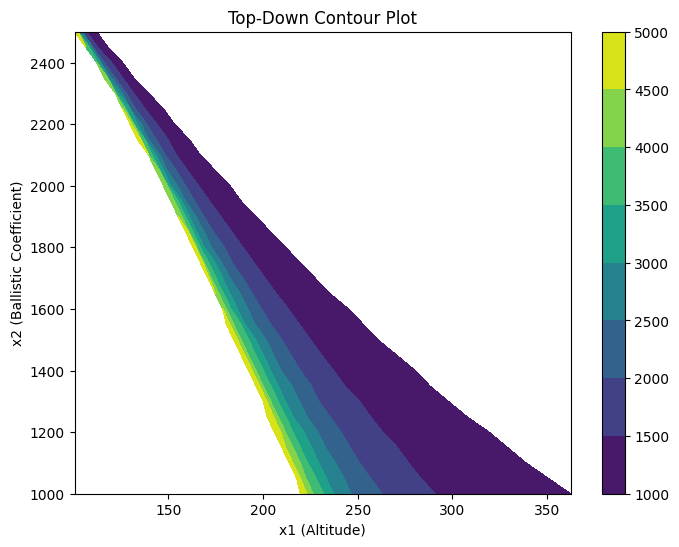

In [138]:
reference_apogee = 3000

altitude_lower_bound = 1000
altitude_upper_bound = 2500

ballistic_coefficient_lower_bound = 1000
ballistic_coefficient_upper_bound = 5000

number_of_points = 1000




axis_length = int(np.sqrt(number_of_points))

altitude = np.linspace(altitude_lower_bound, altitude_upper_bound, axis_length)
ballistic_coefficient = np.linspace(ballistic_coefficient_lower_bound, ballistic_coefficient_upper_bound, axis_length)

x1 = []
x2 = []
y = []

for i in range(axis_length):
    for j in range(axis_length):
        print(f"Generating the training data {np.round(100 * (i * axis_length + j)/axis_length**2, 2)}% complete", end="\r")
        x1.append(altitude[i])
        x2.append(ballistic_coefficient[j])
        y.append(f(reference_apogee, altitude[i], ballistic_coefficient[j])) #np.array(1000,0)

print("\nTraining Network")
x1 = np.array(x1)
x2 = np.array(x2)
y = np.array(y)

x1_origin = x1
x2_origin = x2
y_origin = y

axis_length = int(np.sqrt(len(x1_origin)))  # Assuming the grid is square
x1_mesh_o = x1_origin.reshape(axis_length, axis_length)  # Reshape to 2D grid
x2_mesh_o = x2_origin.reshape(axis_length, axis_length)
y_mesh_o = y_origin.reshape(axis_length, axis_length)

# Plotting the top-down contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(y_mesh_o, x1_mesh_o, x2_mesh_o, cmap='viridis')
plt.colorbar(contour, ax=ax)

ax.set_title('Top-Down Contour Plot')
ax.set_xlabel('x1 (Altitude)')
ax.set_ylabel('x2 (Ballistic Coefficient)')

plt.show()


# Normalize inputs to the range [0, 1]
x1_norm = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
x2_norm = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))

X = np.stack([x1_norm, x2_norm], axis=1)
y = y.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [139]:
# Step 3: Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Two inputs
        self.fc2 = nn.Linear(20, 40)
        self.fc3 = nn.Linear(40, 10)
        self.fc4 = nn.Linear(10, 1)  # Single output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = NeuralNet()

# Step 4: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [140]:
# Step 5: Train the model
epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}", end="\r")

In [141]:
# Step 6: Generate grid for 3D visualization and contour plots
x1_grid = np.linspace(0, 1, axis_length)  # Adjust grid range to match normalization
x2_grid = np.linspace(0, 1, axis_length)
x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)

X_grid = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)

# True function values (un-normalized grid)
x1_true = x1_mesh * (np.max(x1) - np.min(x1)) + np.min(x1)
x2_true = x2_mesh * (np.max(x2) - np.min(x2)) + np.min(x2)

y_true = y.reshape(axis_length, axis_length) # Reshape the origional data for plotting

# Neural network predictions
y_pred = model(X_grid_tensor).detach().numpy().reshape(x1_mesh.shape)



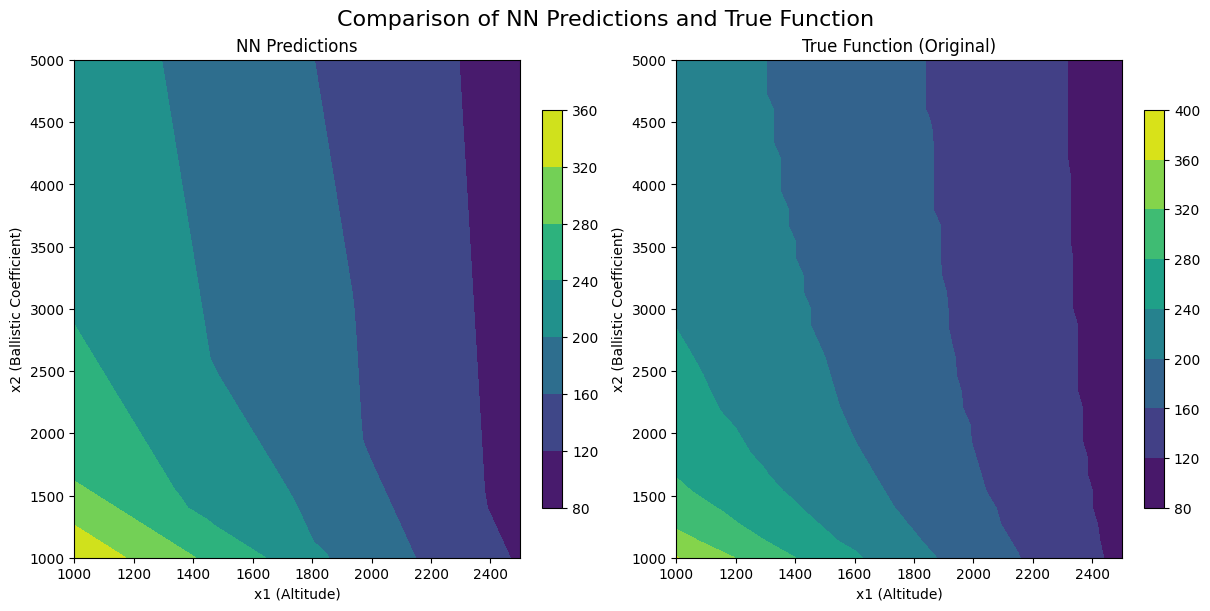

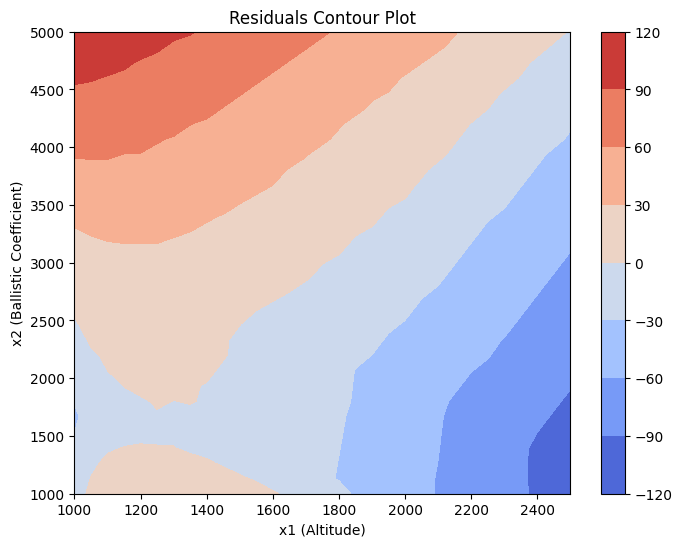

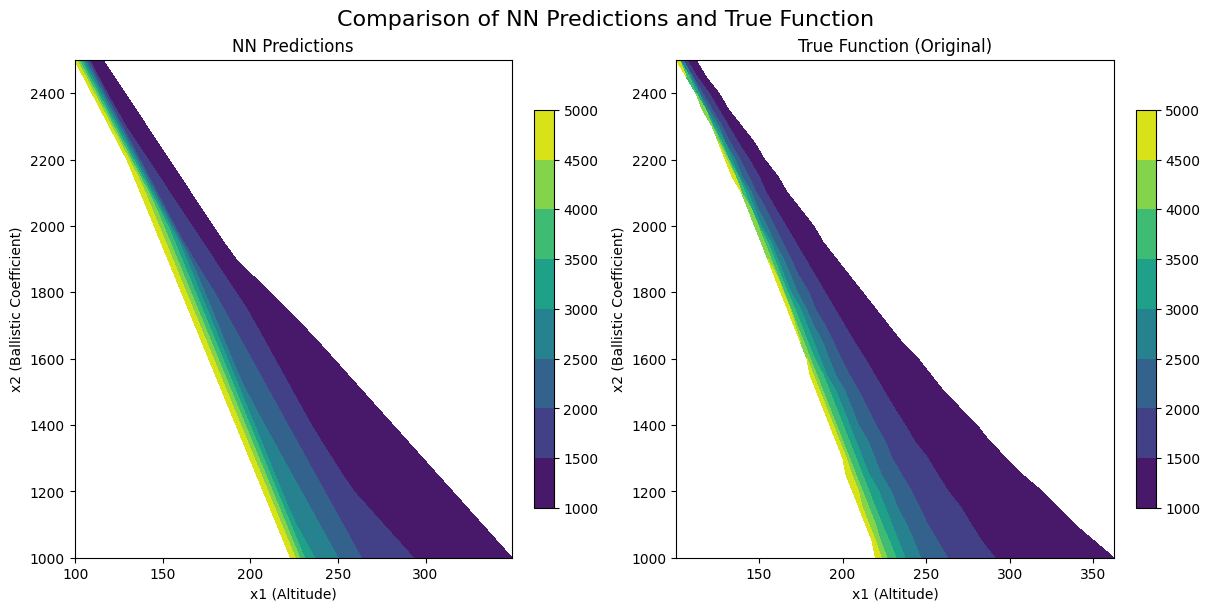

In [142]:

# Assuming y_pred and y_origin are already reshaped to match x1_mesh and x2_mesh
# x1_true, x2_true = un-normalized meshgrid coordinates
# y_pred = model predictions reshaped to grid
# y_origin = true values reshaped to grid
# Ensure y_origin and y_pred are reshaped to the correct 2D grid
y_origin = y_origin.reshape(x1_true.shape)  # Reshape to match grid
y_pred = y_pred.reshape(x1_true.shape)      # Ensure predictions are reshaped



# Plotting side-by-side contour plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Neural Network Prediction Contour
contour1 = axs[0].contourf(x1_true, x2_true, y_pred, cmap='viridis')
axs[0].set_title('NN Predictions')
axs[0].set_xlabel('x1 (Altitude)')
axs[0].set_ylabel('x2 (Ballistic Coefficient)')
fig.colorbar(contour1, ax=axs[0], shrink=0.8)

# True Function Contour
contour2 = axs[1].contourf(x1_mesh_o, x2_mesh_o, y_mesh_o, cmap='viridis')
axs[1].set_title('True Function (Original)')
axs[1].set_xlabel('x1 (Altitude)')
axs[1].set_ylabel('x2 (Ballistic Coefficient)')
fig.colorbar(contour2, ax=axs[1], shrink=0.8)

plt.suptitle('Comparison of NN Predictions and True Function', fontsize=16)
plt.show()




# Ensure residuals are computed and reshaped correctly
residuals = y_pred - y_mesh_o  # Compute residuals

# Plot residuals with your preferred argument order
plt.figure(figsize=(8, 6))
contour = plt.contourf(x1_true, x2_true, residuals, cmap='coolwarm')  # `coolwarm` colormap
plt.colorbar(contour)


# Add labels and title
plt.title('Residuals Contour Plot')
plt.xlabel('x1 (Altitude)')
plt.ylabel('x2 (Ballistic Coefficient)')

plt.show()



# Plotting side-by-side contour plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Neural Network Prediction Contour
contour1 = axs[0].contourf(y_pred, x1_true, x2_true, cmap='viridis')
axs[0].set_title('NN Predictions')
axs[0].set_xlabel('x1 (Altitude)')
axs[0].set_ylabel('x2 (Ballistic Coefficient)')
fig.colorbar(contour1, ax=axs[0], shrink=0.8)

# True Function Contour
contour2 = axs[1].contourf(y_mesh_o, x1_mesh_o, x2_mesh_o, cmap='viridis')
axs[1].set_title('True Function (Original)')
axs[1].set_xlabel('x1 (Altitude)')
axs[1].set_ylabel('x2 (Ballistic Coefficient)')
fig.colorbar(contour2, ax=axs[1], shrink=0.8)

plt.suptitle('Comparison of NN Predictions and True Function', fontsize=16)
plt.show()



